# Resolveノイズ付き結果
- 学習データ数20000

In [1]:
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal, ROUND_HALF_UP
import pickle
import sys
import os
from scipy.constants import mu_0 as mu0

Using TensorFlow backend.


In [2]:
dnn_dir = 'DB/dnn_history/'
model = load_model(dnn_dir + '20210625a_model.h5')
hist_df = pd.read_csv(dnn_dir + '20210625a_history.csv')

In [7]:
#データファイル名の入力
dataset_path = 'DB/dataset/'
file_name = '20210625_a_20000_resolve.csv'

#全体読み込み
data_file_name = dataset_path + file_name
df = pd.read_csv(data_file_name)

#分割
x = df.iloc[:, :11].values
y = df.iloc[:, 11:].values
y = np.log10(y)
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.02, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=0)

#x正規化
sc = preprocessing.StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

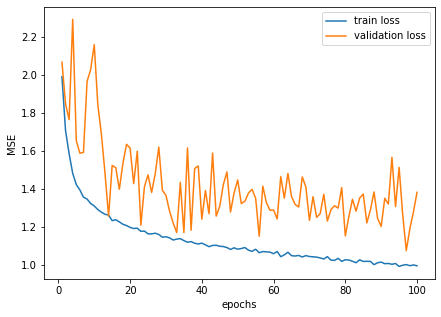

In [8]:
epochs = 100
epochs = np.arange(1, epochs+1)
val_mse = hist_df['val_loss'].values
loss = hist_df['loss'].values

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

ax.plot(epochs, loss, label='train loss')
ax.plot(epochs, val_mse, label='validation loss')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
ax.legend()

Text(0, 0.5, 'Cumulative ratio [%]')

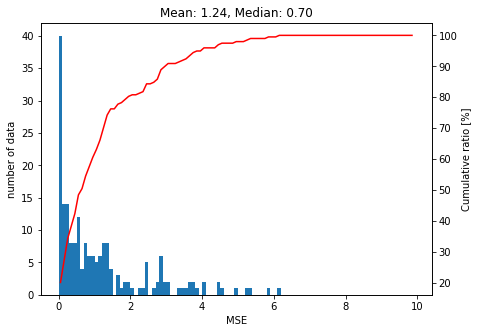

In [11]:
pred = model.predict(x_test)
terr = (y_test - pred)**2
tmse = np.array([k.mean() for k in terr])

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
bins = [.1*(i) for i in range(100)]
n, bins, patches = ax.hist(tmse, bins=bins)
y2 = np.add.accumulate(n) / n.sum() * 100
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
ax.set_xlabel('MSE')
ax.set_ylabel('number of data')
mean = np.mean(tmse)
median = np.median(tmse)
ax.set_title('Mean: {mean:.2f}, Median: {median:.2f}'.format(mean=mean, median=median))

# 第2軸のプロット
bx = ax.twinx()
lines = bx.plot(x2, y2, ls='-', color='r', label='Cumulative ratio')
bx.set_ylabel('Cumulative ratio [%]')

In [17]:
def random_result_viewer(pred, true):
    idlen = pred.shape[0]
    ids = np.array([i for i in range(idlen)])
    chosen = np.random.choice(ids, 9, replace=False)
    thicks = np.ones(20)*10.
    depth = []
    sum_ = 0
    for item in thicks:
        sum_ = sum_ + item
        depth.append(sum_)
    
    fig = plt.figure(figsize=(12, 18), dpi=100)
    ax1 = fig.add_subplot(3,3,1)
    ax2 = fig.add_subplot(3,3,2)
    ax3 = fig.add_subplot(3,3,3)
    ax4 = fig.add_subplot(3,3,4)
    ax5 = fig.add_subplot(3,3,5)
    ax6 = fig.add_subplot(3,3,6)
    ax7 = fig.add_subplot(3,3,7)
    ax8 = fig.add_subplot(3,3,8)
    ax9 = fig.add_subplot(3,3,9)
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
    for i in range(9):
        yp = 10**pred[chosen[i]]
        yt = 10**true[chosen[i]]
        rmspe_res = np.sqrt(np.mean(((yt - yp) / yt)**2)) * 100
        ax = axes[i]
        ax.step(yt, depth, label='true')
        ax.step(yp, depth, label='predict')
        ax.invert_yaxis()
        ax.set_xscale('log')
        ax.set_xlim(1e-2*0.99, 1e4*1.1)
        ax.grid()
        ax.set_xlabel('resistivity[ohm-m]')
        ax.set_ylabel('depth[m]')
        ax.set_title('No.{n} RMSPE: {rmspe_res:.2f}'.format(n=chosen[i], rmspe_res=rmspe_res))
        ax.legend()

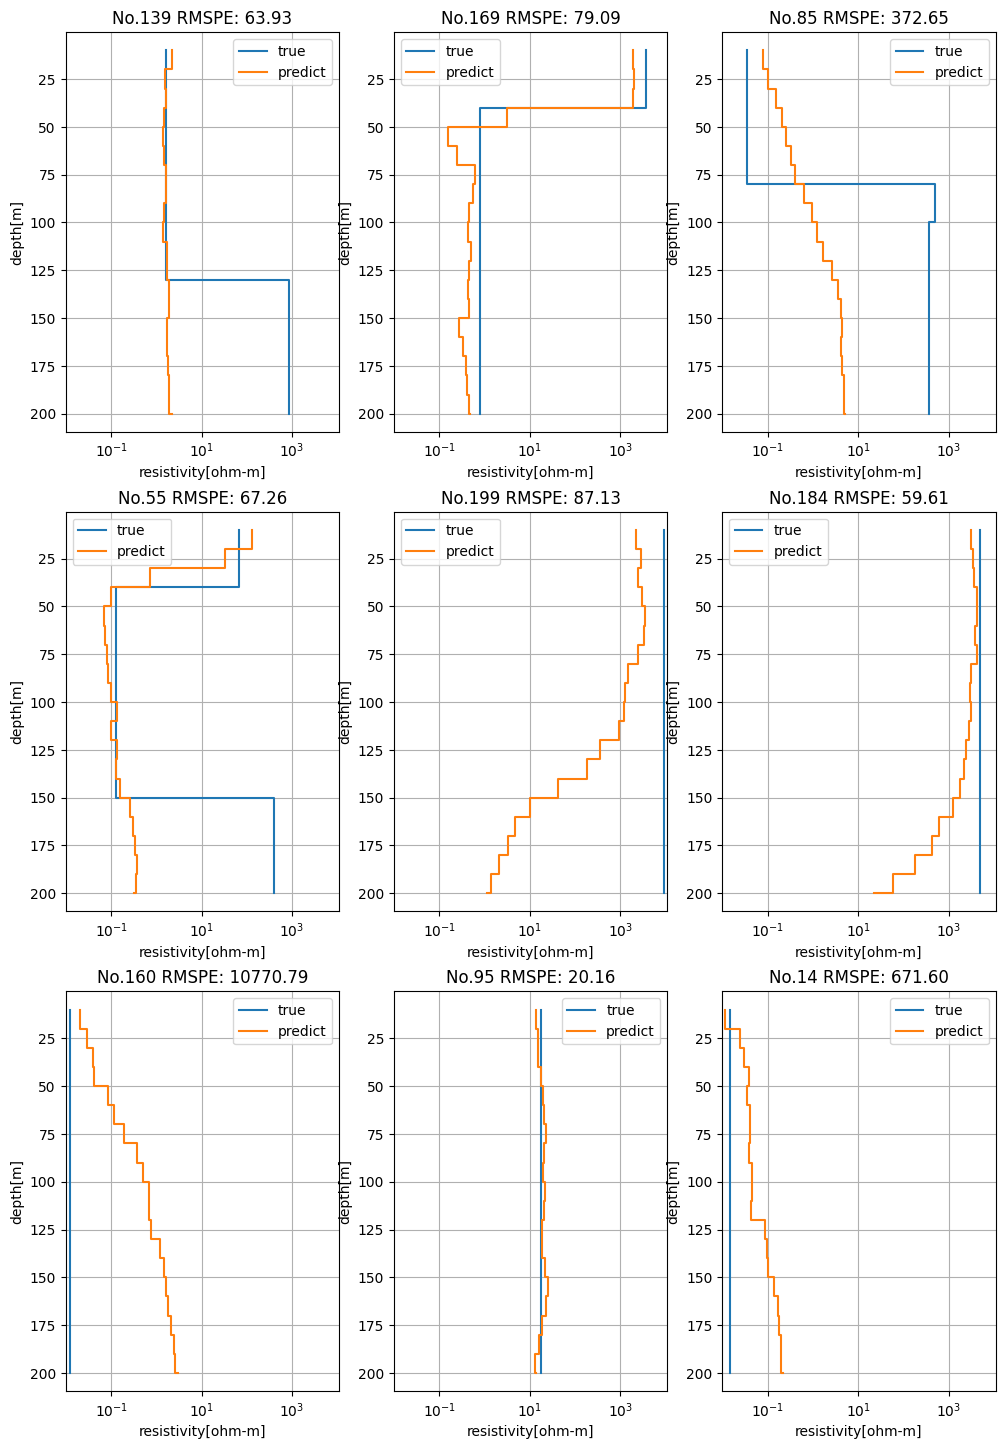

In [23]:
random_result_viewer(pred, y_test)